In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, math
from PyEMD import EMD
from functools import reduce
import statsmodels.api as sm
%matplotlib inline

学习一下包络算法大致上是怎么做的
首先， 我们需要计算滚动轴承的一些基本参数

BPFO,  外圈故障频率  $ BPFO = \dfrac{nf_s}{2}\left\{ 1 + \dfrac{d}{D} cos \alpha \right\} $

BPFI,  内圈故障频率  $ BPFI = \dfrac{nf_s}{2}\left\{ 1 - \dfrac{d}{D} cos \alpha \right\} $

FTF,    轴承基本频率  $ FTF = \dfrac{f_s}{2}\left\{1-\dfrac{d}{D}cos\alpha\right\} $

BSF,   滚珠故障频率  $ BSF = \dfrac{Df_s}{d}\left\{1-\left( \dfrac{d}{D}cos\alpha \right)^2\right\} $

其中$ D, d, \alpha, n, f_s $ 分别代表轴承直径， 滚珠直径， 滚珠和保持架的接触角， 滚珠个数， 轴承旋转频率。

In [2]:
sample_rate = 25600
f_s = 35
pitch_diameter = 39.80  / 1000
ball_diameter = 7.92 / 1000
contact_angle = 0
n_balls = 8
filename = "./35Hz12kN/Bearing1_3/150.csv"
df = pd.read_csv(filename)
df = df.rename(columns={"Horizontal_vibration_signals":"H", "Vertical_vibration_signals":"V"})
df["value"] = np.sqrt(df.H**2 + df.V**2)

In [3]:
# 计算轴承的基本参数

bpfo = n_balls * f_s / 2.0 * ( 1 + ball_diameter / pitch_diameter * math.cos(contact_angle))
bpfi = n_balls * f_s / 2.0 * ( 1 - ball_diameter /pitch_diameter * math.cos(contact_angle))
ftf = f_s / 2.0 * (1 - ball_diameter/pitch_diameter * math.cos(contact_angle))
bsf = pitch_diameter * f_s / ball_diameter * ( 1 - ((ball_diameter / pitch_diameter)*math.cos(contact_angle))**2)
print(f"rotate frequency [{f_s}] \nBPFO [{bpfo}] \nBPFI [{bpfi}] \nFTF [{ftf}] \nBSF [{bsf}]")

rotate frequency [35] 
BPFO [167.85929648241205] 
BPFI [112.14070351758794] 
FTF [14.017587939698492] 
BSF [168.91901426323537]


In [6]:
# 查找合适的ar参数
t = np.linspace(0, 1.28, 32768)
max_iterator = 400
N = len(df.value)
max_kurtosis = -10
max_p = 1
for p in range(1, max_iterator):
    ap, _ = sm.regression.linear_model.yule_walker(df.value, p)
    X = np.zeros((N, p))
    for i in range(0, p):
        X[i:, i] = df.value[0:N-i]
    xp = np.matmul(X , ap)
    e = df.value - xp
    k = sp.stats.kurtosis(e[p+1:])
    if k > max_kurtosis:
        max_kurtosis = k
        max_p = p

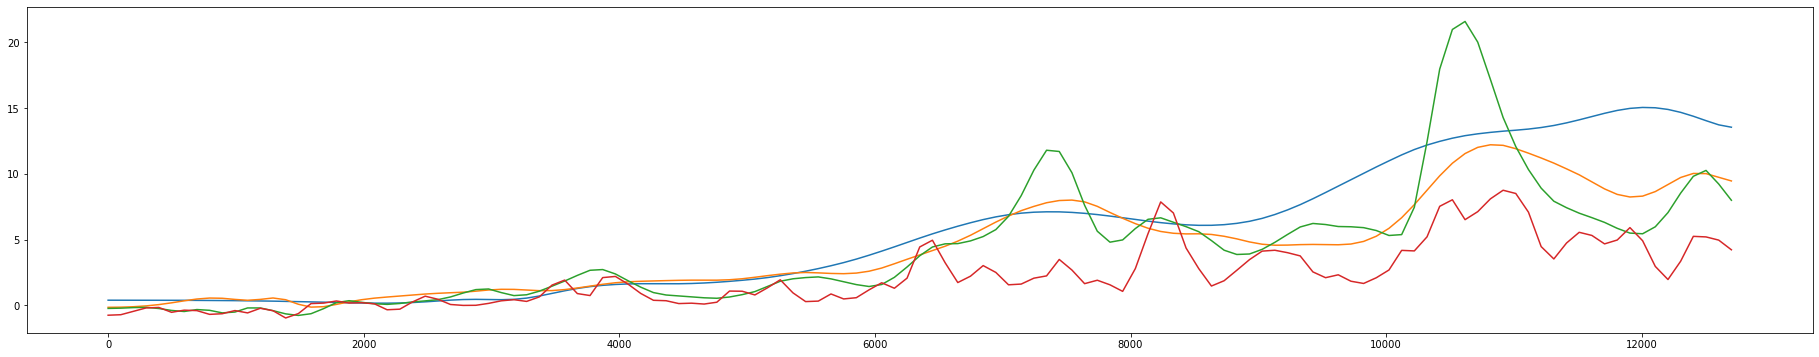

In [8]:
opt_a, _ = sm.regression.linear_model.yule_walker(df.value, max_p)
xp = sp.signal.lfilter(0-opt_a, 1, df.value)
e = df.value[max_p+1:] - xp [max_p+1:]
Ne = len(e)
win_length = [2**4, 2**5, 2**6, 2**7]
num_freq = np.max(win_length) + 1
spectrum_kurt = []

for i in range(len(win_length)):
    win_func = sp.signal.windows.hann(win_length[i])
    num_overlap =int(win_length[i]/2)
    num_window = int((Ne - num_overlap) / (win_length[i] - num_overlap))
    a,b = 0, win_length[i]
    STFT = np.zeros((num_window, num_freq))
    for t in range(0, num_window):
        stft = np.fft.fft(e[a:b] * win_func, 2 * (num_freq -1))
        stft = np.abs(stft[0:num_freq]) / win_length[i]/np.sqrt(np.mean(win_func **2))*2
        STFT[t,:] =  stft
        b += win_length[i] - num_overlap
        a += win_length[i] - num_overlap
    kurt = []
    for j in range(num_freq):
        kurt.append(sp.stats.kurtosis(STFT[:,j]))
    spectrum_kurt.append(kurt)
plt.figure(figsize=(32,6))
freq = np.arange(0, num_freq)/(2 * num_freq) * sample_rate
for i in range(len(spectrum_kurt)):
    plt.plot(freq, spectrum_kurt[i])
plt.show()

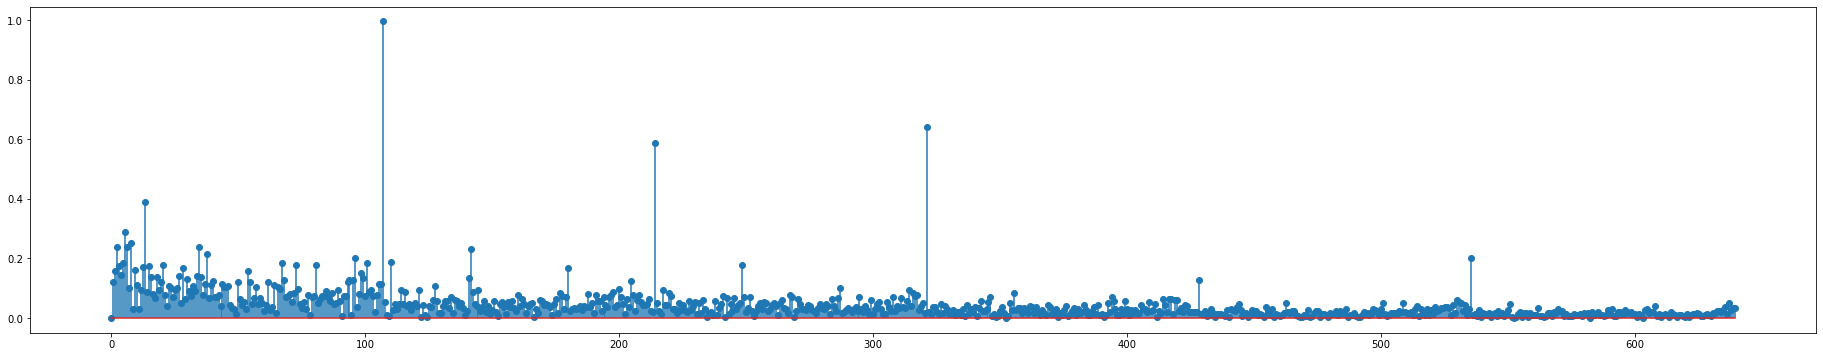

bpfo[167.85929648241205], bpfi[112.14070351758794], ftf[14.017587939698492], bsf[168.91901426323537]


In [10]:
band_pass = np.array([10, 300])
(b, a) = sp.signal.butter(2, band_pass / (sample_rate/2), "bandpass")
X = sp.signal.lfilter(b, a, e)
ax = sp.signal.hilbert(X)
envel = np.abs(ax)
envel = envel - np.mean(envel)
fft_envel = np.abs(np.fft.fft(envel))/Ne * 2;
cutoff = int(N/40)
fft_envel = fft_envel[:cutoff]
freq = np.arange(Ne)/Ne*sample_rate
freq = freq[:cutoff]
plt.figure(figsize=(32,6))
plt.stem(freq, fft_envel)
plt.show()
print(f"bpfo[{bpfo}], bpfi[{bpfi}], ftf[{ftf}], bsf[{bsf}]")